# TechnoSisters - Housing affodability and safety predictoon in Toronto city. Canada

## Code for feature engineering, safety and affodable neighbouhood clustering, and house price predcition

- First the safety index, and afforadbility index is calculated, after that based on this index the clustering is performed to identify the clusters based on income and safety. After that, the negibouhoods are ranked based on the safety and affordable index.

- Price prediction is conduced to see how the prices effect based on the features.

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import folium
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import geopandas as gpd
import pandas as pd

# Load data

In [39]:
df = pd.read_csv('C:\\Users\\mahagam3\\Documents\\CME Course\\Regression_model\\NEW_model_final_features\\Features_after_EDA_Toronto.csv')

# Data preparation

In [40]:
# Replace missing values in numerical columns with their respective mean values
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
df['bath_bed_ratio'] = df['bath_bed_ratio'].fillna(0)  # Replace 0 with the desired default value.

# Normalize numerical features
scaler = MinMaxScaler()
features_to_normalize = ['price', 'area', 'house_density', 'bedrooms', 'bathrooms', 
                         'Total Facilities 500', 'Total Facilities 1000', 'Total Facilities 1500', 
                         'Avg_Faci_500_1500', 'public_transit_best_buffer_area_0.5_values', 
                         'restaurants_best_buffer_area_0.5_values', 
                         'public_service_best_buffer_area_0.5_values', 
                         'other_dailylife_facilities_best_buffer_area_0.5_values']
normalized_features = scaler.fit_transform(df[features_to_normalize])

# Add normalized features back to the DataFrame
normalized_features_df = pd.DataFrame(normalized_features, columns=features_to_normalize)
df.update(normalized_features_df)

C:\Users\mahagam3\AppData\Local\Temp\3\ipykernel_139496\4166563790.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01809099 0.0224445  0.0195266  ... 0.08958542 0.04584607 0.02191636]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(normalized_features_df)
C:\Users\mahagam3\AppData\Local\Temp\3\ipykernel_139496\4166563790.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.36363636 0.45454545 0.36363636 ... 0.81818182 0.81818182 0.18181818]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(normalized_features_df)
C:\Users\mahagam3\AppData\Local\Temp\3\ipykernel_139496\4166563790.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.3 0.2 0.2 ... 0.4 0.3 0. ]' h

# Feature Engineering

The Safety Index is calculated based on the proximity to public services, public transit, restaurants, and other daily life facilities, combined with the Crime_Class, since we do not have a specific. The rank number is given based on the crine level (if low crime=3, moderate crime =2m and high crime=1)

The affordability is evaluated based on the house price, size and neighbohood facilities. The rank number is given (low class =1, middle class =2, and high class =3)


## Calculate the Affordability_index

#### Group by neighbourhood and House_category to calculate the average price and count:
$$
\text{average\_price}_{i,j} = \frac{1}{n_{i,j}} \sum_{k=1}^{n_{i,j}} \text{price}_{i,j,k}
$$
Where $\text{average\_price}_{i,j}$ is the average price for neighbourhood $i$ and house category $j$, and $n_{i,j}$ is the number of houses in that group.

#### Income Score:
$$
\text{Income\_Score}_k = \text{Income\_Class}_k
$$
Where $\text{Income\_Score}_k$ corresponds to a numerical value based on the income class of each entry $k$. The mapping for income classes is:
- Low Class → 3
- Moderate Class → 2
- High Class → 1

#### Facility Score:
$$
\text{Facility\_Score}_k = \text{Total Facilities 500}_k + \text{Total Facilities 1000}_k + \text{Total Facilities 1500}_k
$$
Where $\text{Facility\_Score}_k$ is the sum of the total number of facilities within 500m, 1000m, and 1500m of each house $k$.

#### Affordability Index for house affoddability:
$$
\text{Affordability\_Index}_k = \left( \frac{\text{Income\_Score}_k}{\text{average\_price}_{i,j}} \right) + \text{Facility\_Score}_k
$$
Where ${Affordability\_Index}_k$ is calculated by dividing the income score by the average house price inn each house category of the respective neighbourhood $i$, and then adding the facility score.

#### Average Affordability Index for neighbourhood affodability:
$$
\text{Avg\_Affordability\_Index}_i = \frac{1}{n_i} \sum_{k=1}^{n_i} \text{Affordability\_Index}_k
$$
Where $\text{Avg\_Affordability\_Index}_i$ is the average affordability index for all houses in neighbourhood $i$, and $n_i$ is the number of houses in that neighbourhood.

- House-level affordability helps identify which houses might be affordable or desirable for specific households.
- Neighbourhood-level affordability gives a sense of how accessible or expensive a neighbourhood is overall.

## Data pre-processing

In [41]:
# Map Income Class to Income_Score
income_mapping = {'Low Class': 3, 'Moderate Class': 2, 'High Class': 1}
df['Income_Score'] = df['Income_Class'].map(income_mapping)

# Calculate Facility Score
df['Facility_Score'] = (
    df['Total Facilities 500'] + 
    df['Total Facilities 1000'] + 
    df['Total Facilities 1500']
)

### Check for the ouliers of the features that effect Affodability_index

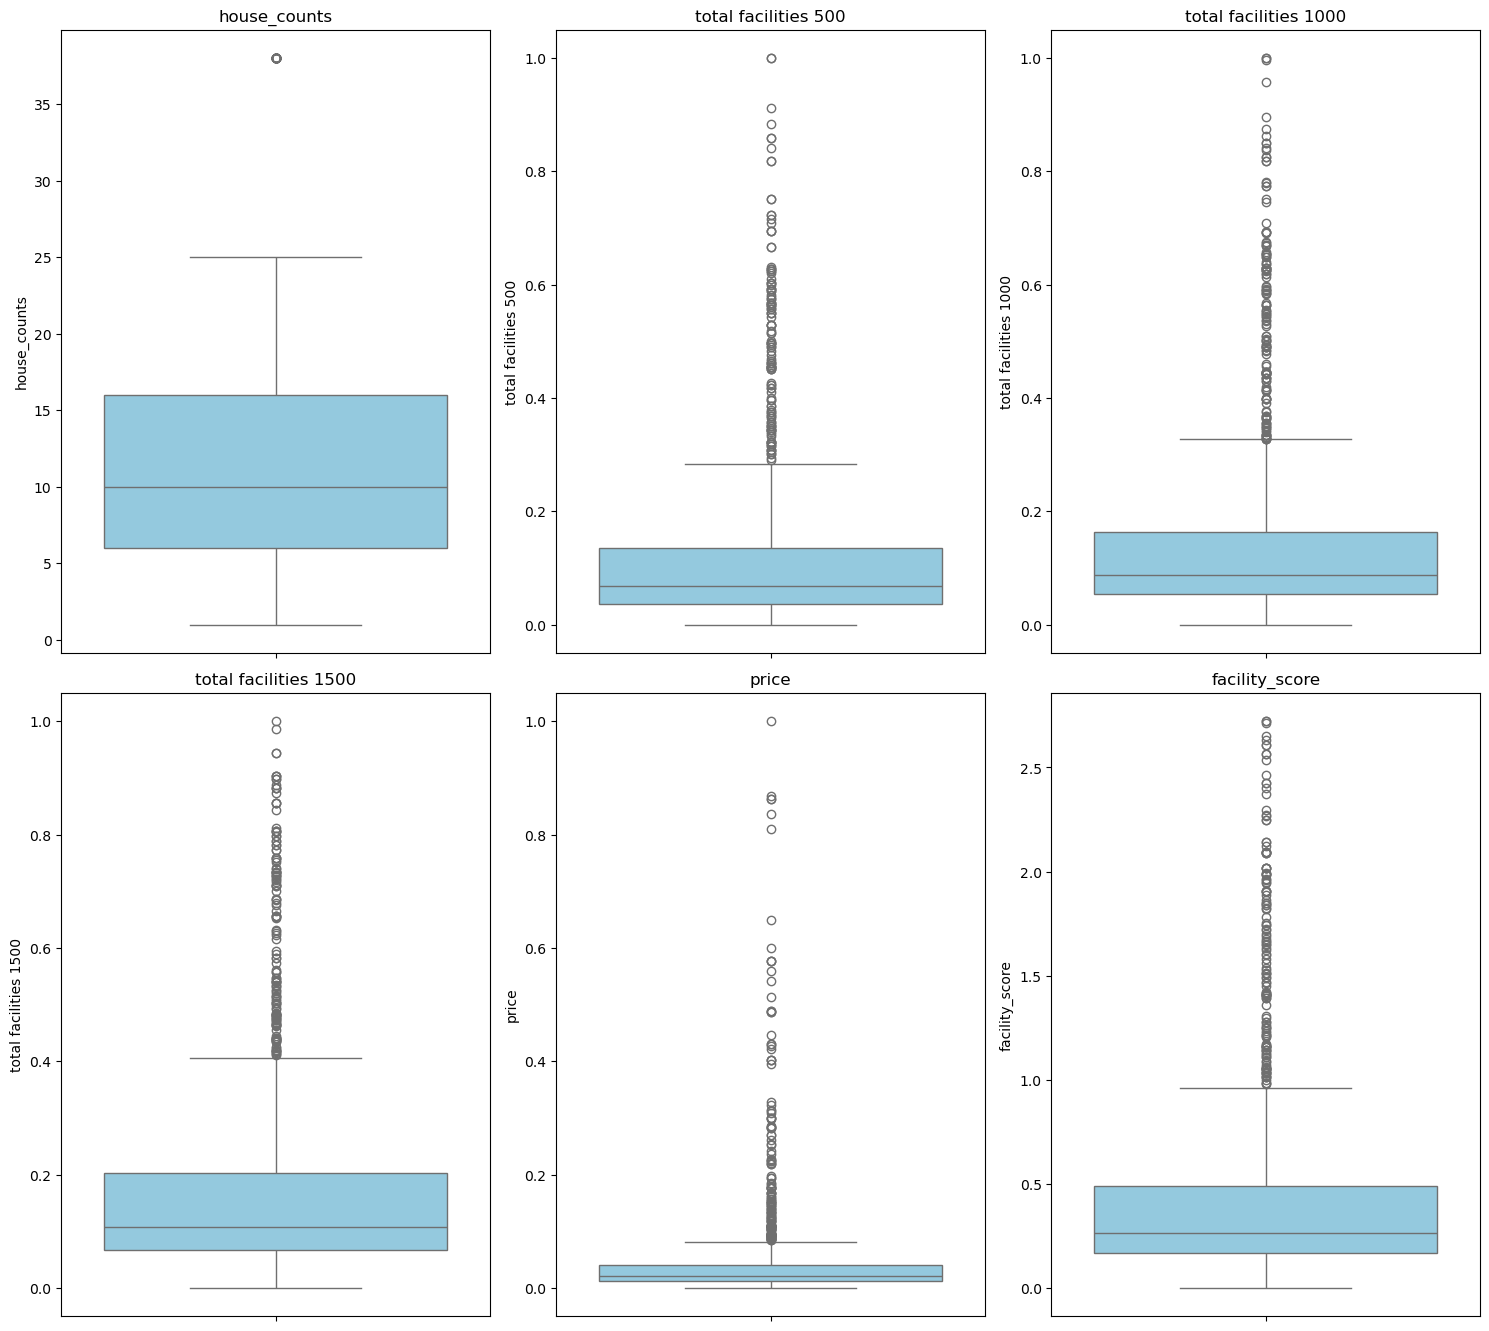

In [42]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Convert all column names to lowercase
df.columns = df.columns.str.lower()

# List of features to analyze (filter based on available columns in the DataFrame)
features = [
    'house_counts', 'total facilities 500', 'total facilities 1000', 'total facilities 1500',
    'price','facility_score']

# Plotting 
plt.figure(figsize=(15, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features) // 3 + 1, 3, i)  # Arrange plots in a grid
    sns.boxplot(y=df[feature], color='skyblue')
    plt.title(feature)
    plt.tight_layout()

plt.show()

*Results analysis:*

Seems like the facitlities are following exponential distribution while price is following 

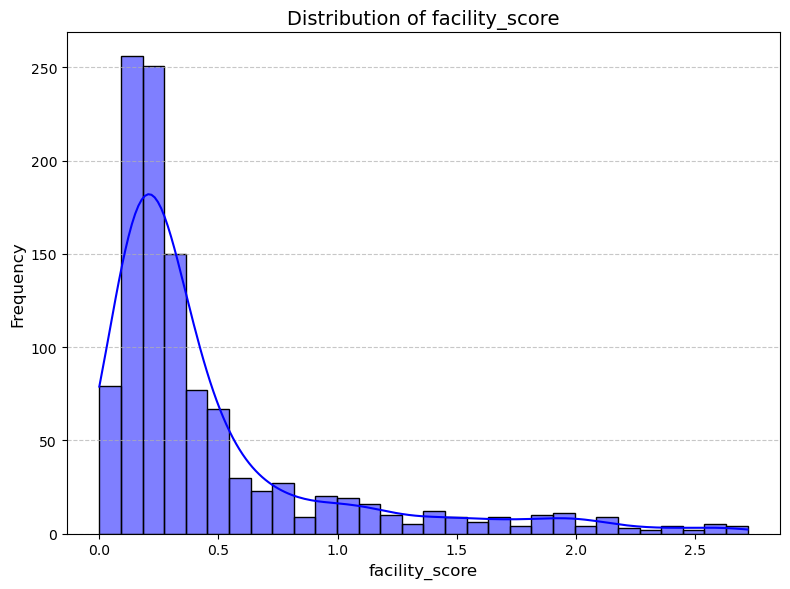

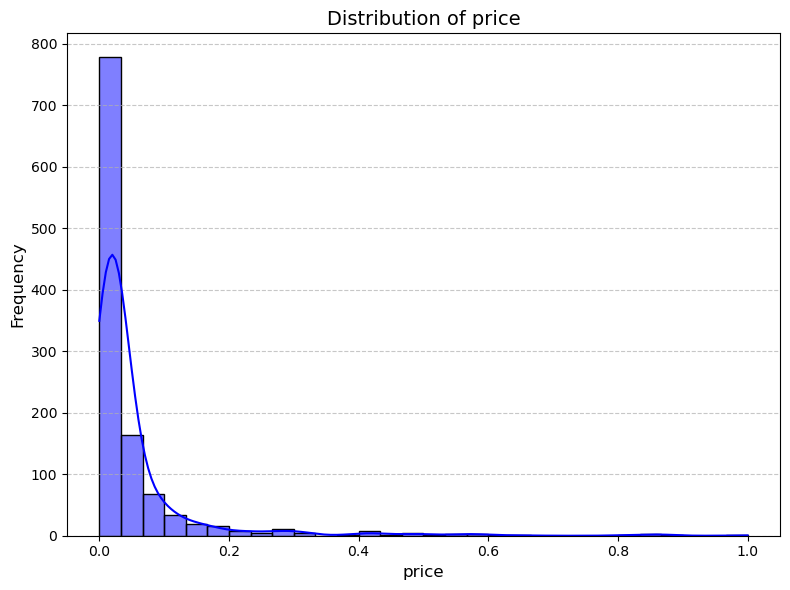

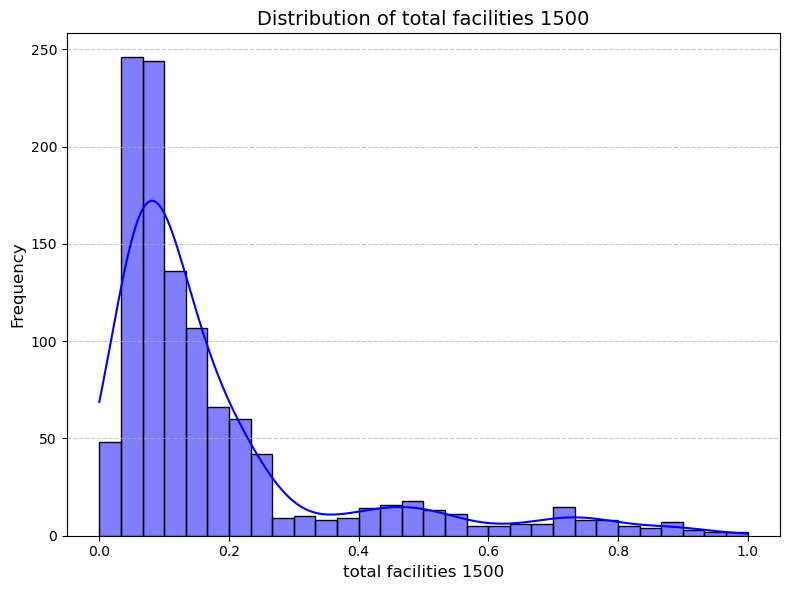

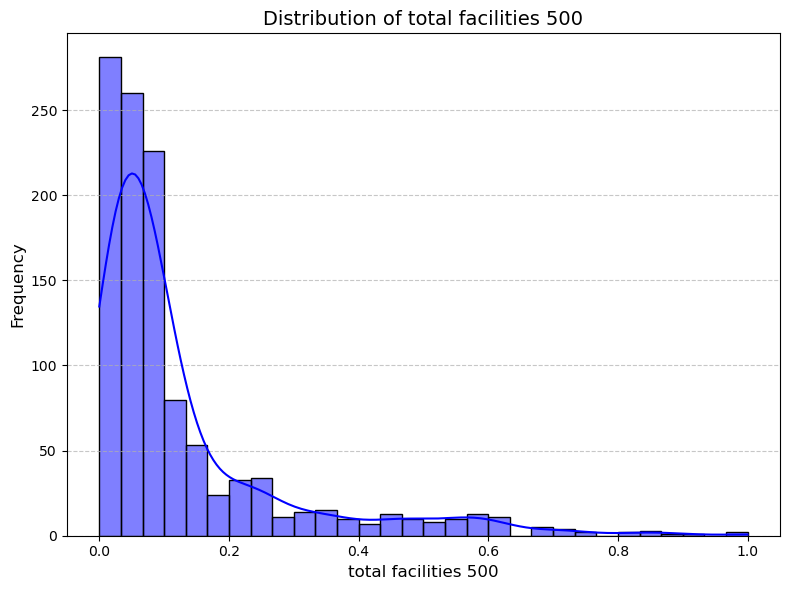

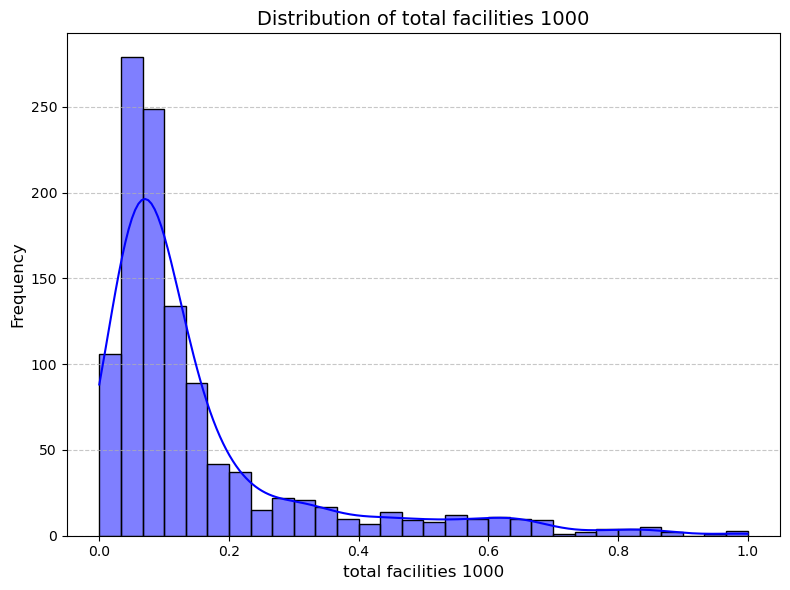

In [43]:
# Identifying the feature distribution of the features with outliers
features_with_outliers = ['facility_score', 'price', 'total facilities 1500', 'total facilities 500', 'total facilities 1000']

# Plotting histograms and KDE for features
for feature in features_with_outliers:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[feature], kde=True, bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

*Results analysis*

Seems the features are mainly exponetial distribution, but the tail of the distribution is not that long. so the IQR filter may work for the oultiler removal

### Remove outliers

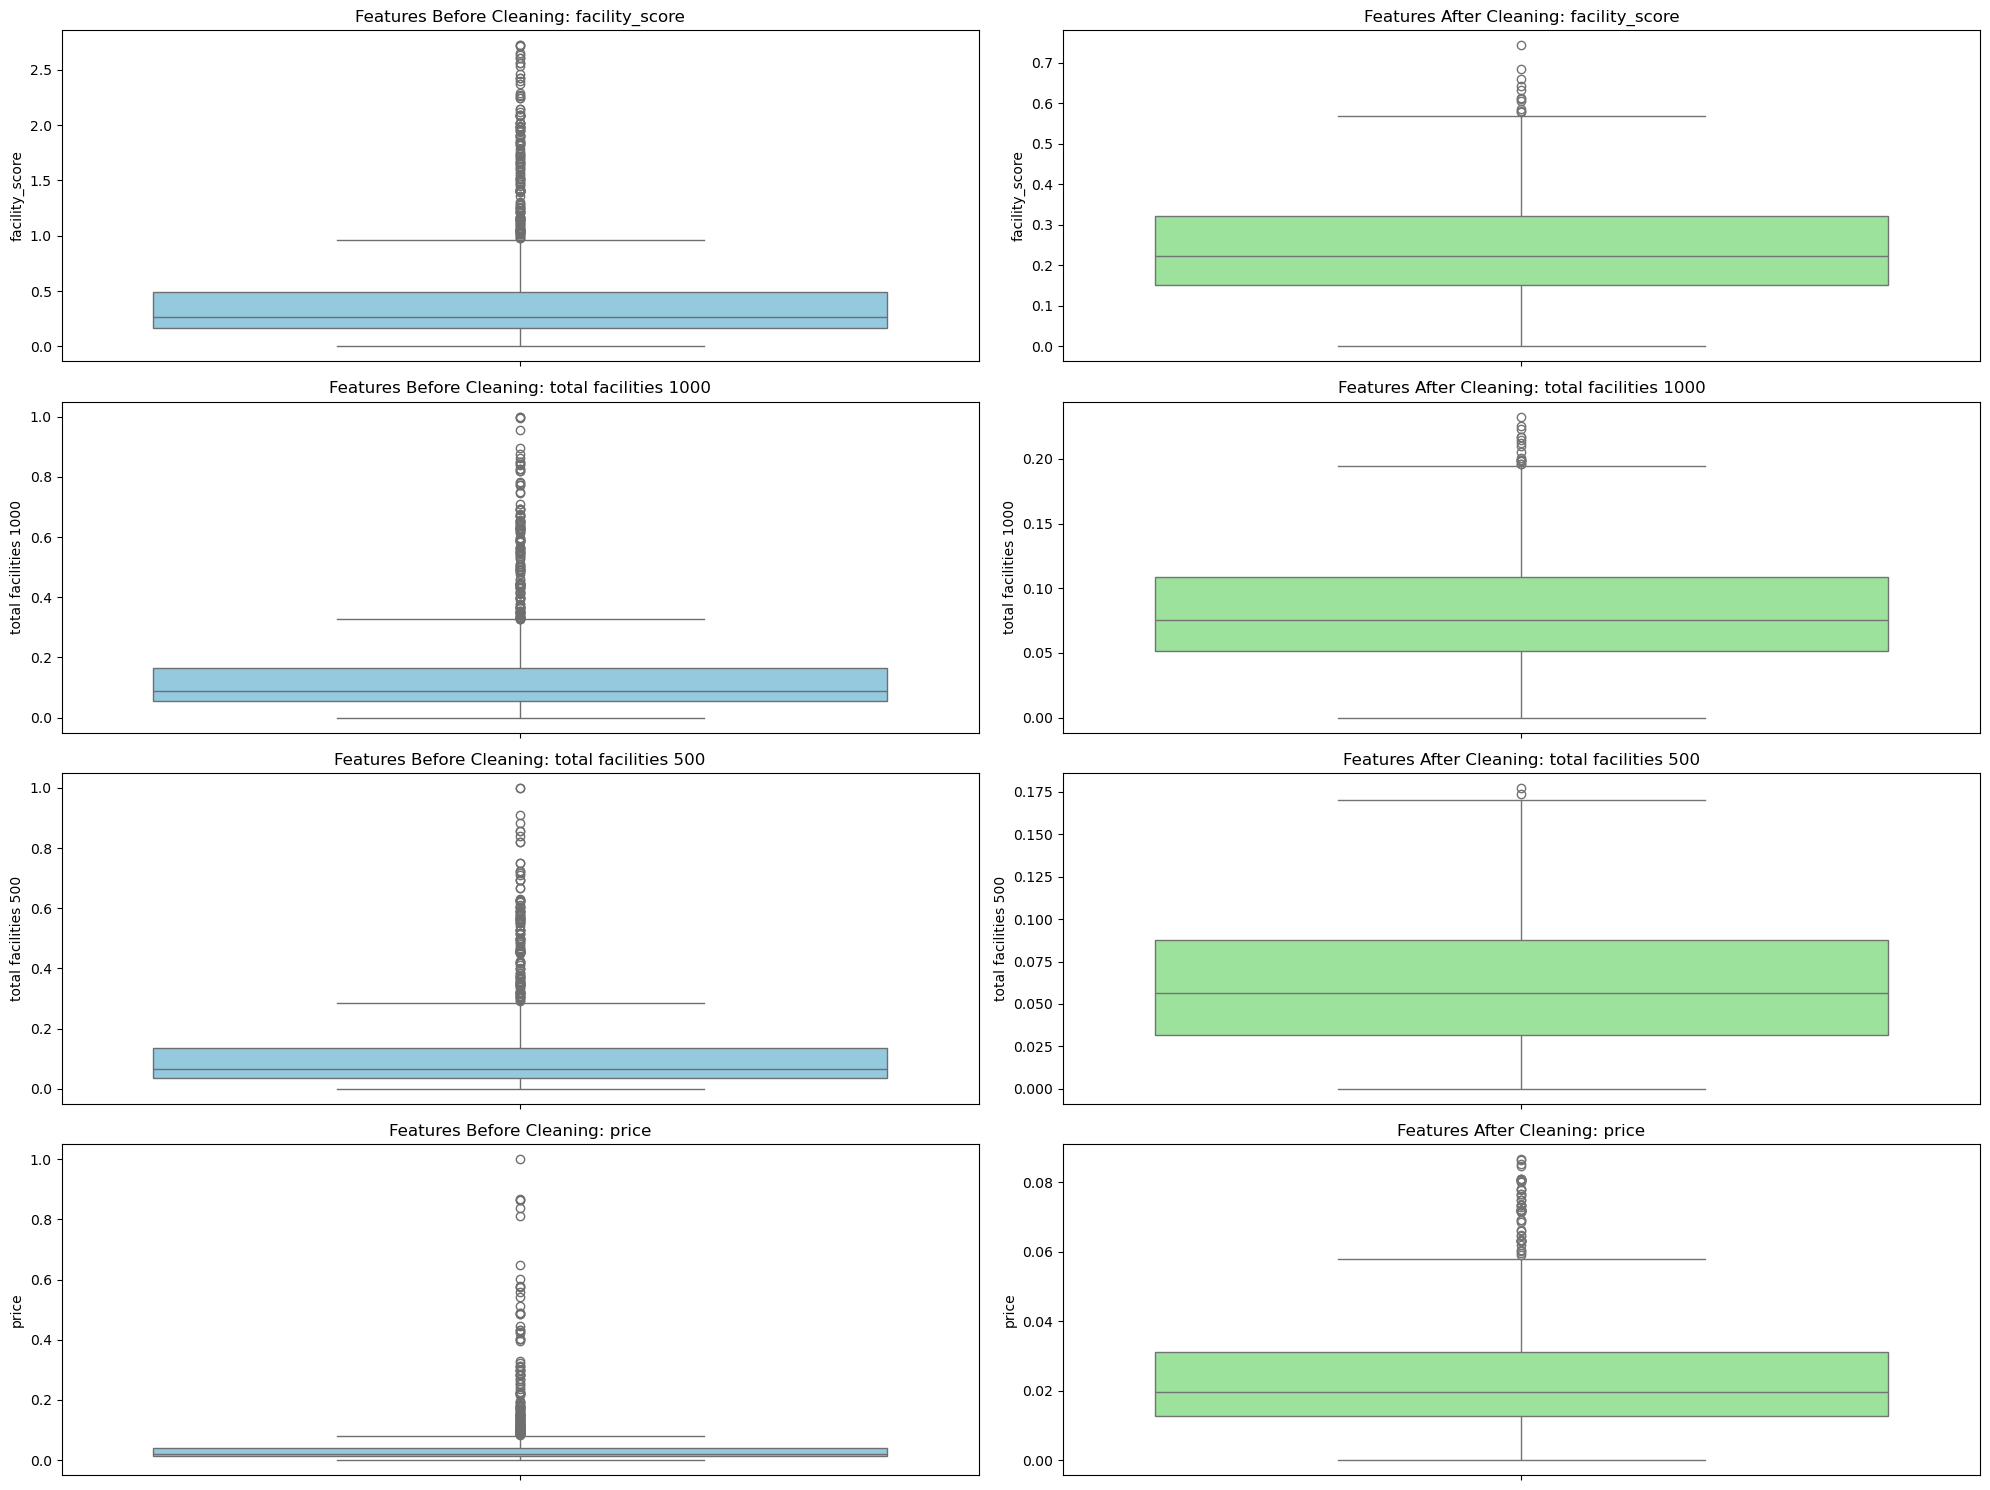

In [44]:
# Features with outliers to process
features_with_outliers = ['facility_score', 'total facilities 1000', 'total facilities 500', 'price']

# Function to remove outliers using IQR
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)  # First quartile
        Q3 = df[feature].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        
        # Define the outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter data within the bounds
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    return df

# Remove outliers 
df_cleaned = remove_outliers(df, features_with_outliers)

# Plot box plots before and after removing outliers
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features_with_outliers, 1):
    plt.subplot(len(features_with_outliers), 2, 2 * i - 1)
    sns.boxplot(y=df[feature], color='skyblue')
    plt.title(f'Features Before Cleaning: {feature}')
    
    plt.subplot(len(features_with_outliers), 2, 2 * i)
    sns.boxplot(y=df_cleaned[feature], color='lightgreen')
    plt.title(f'Features After Cleaning: {feature}')

plt.tight_layout()
plt.show()

### Affodability index calculation

In [45]:
df=df_cleaned
# Group by neighbourhood and House_category to calculate the average price and count
grouped = df.groupby(['neighbourhood_left', 'house_category']).agg(
    average_price=('price', 'mean'),
    count=('price', 'size')
).reset_index()

# If you want to add all counts together for each neighbourhood
total_counts = grouped.groupby('neighbourhood_left')['count'].sum().reset_index()
total_counts.columns = ['neighbourhood_left', 'total_houses']

# Merge the total counts with the grouped DataFrame
result = pd.merge(grouped, total_counts, on='neighbourhood_left')

# Merge the total houses count into the original df for affordability calculation
df = pd.merge(df, result[['neighbourhood_left', 'average_price']], on='neighbourhood_left', how='left')

# Calculate Affordability Index
df['Affordability_Index'] = (df['income_score'] / df['average_price']) + df['facility_score']

# Aggregate the Affordability Index by neighbourhood_left
affordability_by_neighbourhood = df.groupby('neighbourhood_left')['Affordability_Index'].mean().reset_index()

# Print the result for each neighbourhood
print(affordability_by_neighbourhood)

               neighbourhood_left  Affordability_Index
0                 agincourt north           162.133857
1    agincourt south malvern west           177.897953
2                       alderwood           125.026109
3                           annex            32.645498
4                        avondale           142.016468
..                            ...                  ...
137                   yonge doris           124.951984
138                yonge eglinton            19.323282
139                yonge st clair            39.279869
140       york university heights           230.706149
141            yorkdale glen park            87.654261

[142 rows x 2 columns]


### Safety class based on a score

Minor crime = score 3
Moderate crime = score 2
Severe crime = scre 1

In [46]:
# Map Crime_Class to Crime_Score
crime_mapping = {'Minor Crime': 3, 'Moderate Crime': 2, 'Severe Crime': 1}
df['Safety_Index'] = df['crime_class'].map(crime_mapping)

# Aggregate the Affordability Index by neighbourhood_left
safety_by_neighbourhood = df.groupby('neighbourhood_left')['Safety_Index'].mean().reset_index()

# Print the result for each neighbourhood
print(safety_by_neighbourhood)

               neighbourhood_left  Safety_Index
0                 agincourt north           2.0
1    agincourt south malvern west           2.0
2                       alderwood           2.0
3                           annex           2.0
4                        avondale           2.0
..                            ...           ...
137                   yonge doris           2.0
138                yonge eglinton           2.0
139                yonge st clair           2.0
140       york university heights           2.0
141            yorkdale glen park           2.0

[142 rows x 2 columns]


In [47]:
df.head()

index          street address   latitude  longitude  \
0      0  435 middlefield rd #56  43.808839 -79.256579   
1      0  435 middlefield rd #56  43.808839 -79.256579   
2      1          78 ashridge dr  43.815736 -79.268628   
3      1          78 ashridge dr  43.815736 -79.268628   
4      2        48 ardgowan cres  43.812243 -79.271403   

                                      geometry neighbourhood_left  \
0  POINT (640226.2005509724 4852118.588431975)    agincourt north   
1  POINT (640226.2005509724 4852118.588431975)    agincourt north   
2  POINT (639241.0382690977 4852864.261428865)    agincourt north   
3  POINT (639241.0382690977 4852864.261428865)    agincourt north   
4  POINT (639025.9696566293 4852471.639622301)    agincourt north   

  neighbourhood_names      area  house_density     price  ...  \
0     agincourt north  0.230639       0.010677  0.018091  ...   
1     agincourt north  0.230639       0.010677  0.018091  ...   
2     agincourt north  0.230639       0.010677  0.022445  ...   
3     agincourt north  0.230639       0.010677  0.022445  ...   
4     agincourt north  0.230639       0.010677  0.019527  ...   

  avg_faci_500_1500  public_transit_best_buffer_area_0.5_values  \
0          0.035398                                    0.166667   
1          0.035398                                    0.166667   
2          0.067004                                    0.250000   
3          0.067004                                    0.250000   
4          0.062790                                    0.104167   

   restaurants_best_buffer_area_0.5_values  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                 0.000000   
4                                 0.017699   

   public_service_best_buffer_area_0.5_values  \
0                                    0.000000   
1                                    0.000000   
2                                    0.026316   
3                                    0.026316   
4                                    0.105263   

   other_dailylife_facilities_best_buffer_area_0.5_values  income_score  \
0                                                0.0                  3   
1                                                0.0                  3   
2                                                0.0                  3   
3                                                0.0                  3   
4                                                0.0                  3   

   facility_score average_price Affordability_Index  Safety_Index  
0        0.088438      0.022445          133.751465             2  
1        0.088438      0.015761          190.436994             2  
2        0.169109      0.022445          133.832136             2  
3        0.169109      0.015761          190.517665             2  
4        0.161928      0.022445          133.824955             2  

[5 rows x 32 columns]

## Feature scaling and normalization

In [48]:
# Replace inf/-inf with NaN
df['Affordability_Index'] = df['Affordability_Index'].replace([np.inf, -np.inf], np.nan)

# Replace NaN with the column's finite max or mean
finite_max = df['Affordability_Index'][~df['Affordability_Index'].isna()].max()
df['Affordability_Index'] = df['Affordability_Index'].fillna(finite_max)

# Fill remaining NaN with column mean
df['Affordability_Index'] = df['Affordability_Index'].fillna(df['Affordability_Index'].mean())

# scaler = MinMaxScaler()
# df[['Safety_Index', 'Affordability_Index']] = scaler.fit_transform(df[['Safety_Index', 'Affordability_Index']])

# Initialize the imputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')

# Impute missing values in 'Safety_Index' and 'Affordability_Index'
df[['Safety_Index', 'Affordability_Index']] = imputer.fit_transform(df[['Safety_Index', 'Affordability_Index']])

In [49]:
df.head()

index          street address   latitude  longitude  \
0      0  435 middlefield rd #56  43.808839 -79.256579   
1      0  435 middlefield rd #56  43.808839 -79.256579   
2      1          78 ashridge dr  43.815736 -79.268628   
3      1          78 ashridge dr  43.815736 -79.268628   
4      2        48 ardgowan cres  43.812243 -79.271403   

                                      geometry neighbourhood_left  \
0  POINT (640226.2005509724 4852118.588431975)    agincourt north   
1  POINT (640226.2005509724 4852118.588431975)    agincourt north   
2  POINT (639241.0382690977 4852864.261428865)    agincourt north   
3  POINT (639241.0382690977 4852864.261428865)    agincourt north   
4  POINT (639025.9696566293 4852471.639622301)    agincourt north   

  neighbourhood_names      area  house_density     price  ...  \
0     agincourt north  0.230639       0.010677  0.018091  ...   
1     agincourt north  0.230639       0.010677  0.018091  ...   
2     agincourt north  0.230639       0.010677  0.022445  ...   
3     agincourt north  0.230639       0.010677  0.022445  ...   
4     agincourt north  0.230639       0.010677  0.019527  ...   

  avg_faci_500_1500  public_transit_best_buffer_area_0.5_values  \
0          0.035398                                    0.166667   
1          0.035398                                    0.166667   
2          0.067004                                    0.250000   
3          0.067004                                    0.250000   
4          0.062790                                    0.104167   

   restaurants_best_buffer_area_0.5_values  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                 0.000000   
4                                 0.017699   

   public_service_best_buffer_area_0.5_values  \
0                                    0.000000   
1                                    0.000000   
2                                    0.026316   
3                                    0.026316   
4                                    0.105263   

   other_dailylife_facilities_best_buffer_area_0.5_values  income_score  \
0                                                0.0                  3   
1                                                0.0                  3   
2                                                0.0                  3   
3                                                0.0                  3   
4                                                0.0                  3   

   facility_score average_price Affordability_Index  Safety_Index  
0        0.088438      0.022445          133.751465           2.0  
1        0.088438      0.015761          190.436994           2.0  
2        0.169109      0.022445          133.832136           2.0  
3        0.169109      0.015761          190.517665           2.0  
4        0.161928      0.022445          133.824955           2.0  

[5 rows x 32 columns]

In [50]:
print(df[['Safety_Index', 'Affordability_Index']].describe())

       Safety_Index  Affordability_Index
count        2044.0          2044.000000
mean            2.0           144.488949
std             0.0           203.555450
min             2.0            11.804718
25%             2.0            53.357489
50%             2.0            96.202455
75%             2.0           166.331358
max             2.0          2266.136673


In [51]:
# Neighborhood-Level Aggregation
neighborhood_summary = df.groupby('neighbourhood_left').agg({
    'Safety_Index': 'mean',
    'Affordability_Index': 'mean'
}).reset_index()
print(neighborhood_summary.columns)

Index(['neighbourhood_left', 'Safety_Index', 'Affordability_Index'], dtype='object')


# EDA for the safety and affodability index

*Heatmap:* This plot shows the safety levels of different neighborhoods in Toronto.

Hotter spots (with higher Safety_Index values) indicate neighborhoods that are perceived as safer.

Colder spots (lower Safety_Index) represent neighborhoods with lower safety levels.


The heatmap is based on the neighborhood geometries, not individual house locations. Specifically, the plot uses the centroids (geometric center) of the neighborhoods to represent their locations. This means each data point on the heatmap corresponds to a neighborhood, and the heatmap visualizes the Safety_Index for each neighborhood in Toronto.

## Based on Safety index

Hot colour to cooler colour shows how safety is low to high

In [52]:
# Load the Toronto neighborhood geometries
toronto_shapefile = gpd.read_file('Neighbourhoods v2_region.shp')

# Clean up columns by stripping spaces and making the case consistent
toronto_shapefile['NAME'] = toronto_shapefile['NAME'].str.strip().str.lower()
neighborhood_summary['neighbourhood_left'] = neighborhood_summary['neighbourhood_left'].str.strip().str.lower()

# Perform an outer merge to inspect non-matching rows
merged_data = toronto_shapefile.merge(neighborhood_summary, left_on='NAME', right_on='neighbourhood_left', how='outer')

# Filter out rows with missing data
merged_data = merged_data.dropna(subset=['Safety_Index', 'geometry'])

# Reproject the geometries to geographic coordinates (latitude, longitude)
merged_data = merged_data.set_geometry('geometry')
merged_data = merged_data.to_crs(epsg=4326)

# Scale the Safety_Index and Affordability_Index using MinMaxScaler
scaler = MinMaxScaler()
merged_data[['Safety_Index']] = scaler.fit_transform(merged_data[['Safety_Index']])

# Prepare data for the heatmap (latitude, longitude, Safety_Index as the weight)
heatmap_data = []

for index, row in merged_data.iterrows():
    # Ensure there is valid geometry and Safety_Index data
    if pd.notnull(row['Safety_Index']) and row.geometry is not None:
        lat, lon = row.geometry.centroid.y, row.geometry.centroid.x
        # Use the scaled Safety_Index as the weight for the heatmap
        heatmap_data.append([lat, lon, row['Safety_Index']])

# Initialize the map centered around Toronto
toronto_map = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Create and add the heatmap
HeatMap(heatmap_data).add_to(toronto_map)

# Display the map (ensure this works in Jupyter)
toronto_map


*Resulst analysis*

It can be seem that alomost all the neighbouhoods are somewhat safe.


## Based on Affodability index

Hot colour to cooler colour shows how affodable is low to high

In [53]:
# Load the Toronto neighborhood geometries
toronto_shapefile = gpd.read_file('Neighbourhoods v2_region.shp')

# Clean up columns by stripping spaces and making the case consistent
toronto_shapefile['NAME'] = toronto_shapefile['NAME'].str.strip().str.lower()
neighborhood_summary['neighbourhood_left'] = neighborhood_summary['neighbourhood_left'].str.strip().str.lower()

# Perform an outer merge to inspect non-matching rows
merged_data = toronto_shapefile.merge(neighborhood_summary, left_on='NAME', right_on='neighbourhood_left', how='outer')

# Filter out rows with missing data
merged_data = merged_data.dropna(subset=['Affordability_Index', 'geometry'])

# Reproject the geometries to geographic coordinates (latitude, longitude)
merged_data = merged_data.set_geometry('geometry')
merged_data = merged_data.to_crs(epsg=4326)

# Scale the Affordability_Index using MinMaxScaler
scaler = MinMaxScaler()
merged_data['Affordability_Index'] = scaler.fit_transform(merged_data[['Affordability_Index']])

# Prepare data for the heatmap (latitude, longitude, Affordability_Index as the weight)
heatmap_data = []

for index, row in merged_data.iterrows():
    # Ensure there is valid geometry and Affordability_Index data
    if pd.notnull(row['Affordability_Index']) and row.geometry is not None:
        lat, lon = row.geometry.centroid.y, row.geometry.centroid.x
        # Use the scaled Affordability_Index as the weight for the heatmap
        heatmap_data.append([lat, lon, row['Affordability_Index']])

# Initialize the map centered around Toronto
toronto_map = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Create and add the heatmap
HeatMap(heatmap_data).add_to(toronto_map)

# Display the map (ensure this works in Jupyter)
toronto_map


*Results analysis*

Can see there are less affodable neighbouhood is near Vaughan, and other neighbouhoods are seemly moderetly affodable

## Based on both affordable and safety index

In [54]:
# Load the Toronto neighborhood geometries
toronto_shapefile = gpd.read_file('Neighbourhoods v2_region.shp')

# Clean up columns by stripping spaces and making the case consistent
toronto_shapefile['NAME'] = toronto_shapefile['NAME'].str.strip().str.lower()
neighborhood_summary['neighbourhood_left'] = neighborhood_summary['neighbourhood_left'].str.strip().str.lower()

# Perform an outer merge to inspect non-matching rows
merged_data = toronto_shapefile.merge(neighborhood_summary, left_on='NAME', right_on='neighbourhood_left', how='outer')

# Filter out rows with missing data for both indices and geometry
merged_data = merged_data.dropna(subset=['Safety_Index', 'Affordability_Index', 'geometry'])

# Reproject the geometries to geographic coordinates (latitude, longitude)
merged_data = merged_data.set_geometry('geometry')
merged_data = merged_data.to_crs(epsg=4326)

# Prepare data for the heatmap (latitude, longitude, Safety_Index and Affordability_Index as the weights)
safety_heatmap_data = []
affordability_heatmap_data = []

for index, row in merged_data.iterrows():
    # Ensure there is valid geometry and both indices data
    if pd.notnull(row['Safety_Index']) and pd.notnull(row['Affordability_Index']) and row.geometry is not None:
        lat, lon = row.geometry.centroid.y, row.geometry.centroid.x
        safety_heatmap_data.append([lat, lon, row['Safety_Index']])
        affordability_heatmap_data.append([lat, lon, row['Affordability_Index']])

# Initialize the map centered around Toronto
toronto_map = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Add the Safety Index heatmap layer
HeatMap(safety_heatmap_data, name="Safety Index", max_zoom=13).add_to(toronto_map)

# Add the Affordability Index heatmap layer
HeatMap(affordability_heatmap_data, name="Affordability Index", max_zoom=13).add_to(toronto_map)

# Add a Layer Control so you can toggle between the layers
folium.LayerControl().add_to(toronto_map)

# Display the map (ensure this works in Jupyter)
toronto_map

# Neighborhood Clustering - using K-mean for affodability analysis

Since we already categorise the negibouhood based on safety in our EDA, now we apply K-means clustering to identify the affodability of the neighbouhoods.

silhouette_score is a statistical evaluation which is popular in unsupervised learning. if the score is:

*0.71 — 1	A strong structure is found*

*0.51 — 0.7	A reasonable structure is found*

*0.26 — 0.5	The found structure might be artificial*

*< 0.26	No structure is found*

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Aggregate data by neighborhood
df_neigh = df.groupby('neighbourhood_left')[['Affordability_Index']].mean().reset_index()

# Ensuring uniqueness for neighborhoods by grouping and getting the first occurrence
df_unique_neigh = df_neigh.reset_index()

# Apply K-Means clustering using only the Affordability_Index
kmeans = KMeans(n_clusters=3, random_state=42)
df_neigh['KMeans_Cluster'] = kmeans.fit_predict(df_neigh[['Affordability_Index']])

# Calculate silhouette score for K-Means clusters
silhouette = silhouette_score(df_neigh[['Affordability_Index']], df_neigh['KMeans_Cluster'])
print(f"Silhouette Score: {silhouette}")

# Map clusters to meaningful names based on centroids
cluster_labels = {i: f"Cluster {i}" for i in range(kmeans.n_clusters)}
df_neigh['KMeans_Label'] = df_neigh['KMeans_Cluster'].map(cluster_labels)

# Perform the merge
df_unique_neigh = df_unique_neigh.merge(
    df_neigh[['neighbourhood_left', 'KMeans_Cluster', 'KMeans_Label']],  # Select only relevant columns
    on='neighbourhood_left',  # Merge on the neighborhood column
    how='left'  # Retain all rows from df_unique_neigh
)

# Analyze centroids for additional insights
print("K-Means Cluster Centroids (based on Affordability Index):")
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i}: Affordability_Index = {center[0]:.2f}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.5968686643247846
K-Means Cluster Centroids (based on Affordability Index):
Cluster 0: Affordability_Index = 91.99
Cluster 1: Affordability_Index = 252.70
Cluster 2: Affordability_Index = 748.66


In [56]:
df_unique_neigh.describe()

index  Affordability_Index  KMeans_Cluster
count  142.000000           142.000000       142.00000
mean    70.500000           129.434975         0.21831
std     41.135953            97.812378         0.43133
min      0.000000            13.342876         0.00000
25%     35.250000            64.225307         0.00000
50%     70.500000           111.405186         0.00000
75%    105.750000           165.620204         0.00000
max    141.000000           748.657117         2.00000

In [57]:
# Count the number of unique neighborhoods in each cluster based on the Cluster_Label
neighbourhood_counts = df_unique_neigh.groupby('KMeans_Label')['neighbourhood_left'].nunique()

# Print the count of unique neighborhoods in each cluster
print(neighbourhood_counts)

KMeans_Label
Cluster 0    112
Cluster 1     29
Cluster 2      1
Name: neighbourhood_left, dtype: int64


In [58]:
# Define the thresholds
# low_affordability_threshold = df_neigh['Affordability_Index'].max()/2  
# high_affordability_threshold = df_neigh['Affordability_Index'].mean() 

low_affordability_threshold = df_neigh['Affordability_Index'].quantile(0.50)  
high_affordability_threshold = df_neigh['Affordability_Index'].quantile(0.25)
,
# Function to assign labels based on affordability index
def assign_affordability_label(affordability_index):
    if affordability_index >= low_affordability_threshold:
        return  "High Affordability"
    elif affordability_index > high_affordability_threshold and affordability_index < low_affordability_threshold:
        return "Moderate Affordability"
    else:
        return "Low Affordability"
# Apply the function to the centroids of each cluster
cluster_labels = {
    0: assign_affordability_label(kmeans.cluster_centers_[0][0]),
    1: assign_affordability_label(kmeans.cluster_centers_[1][0]),
    2: assign_affordability_label(kmeans.cluster_centers_[2][0]),
}

# Map the cluster labels to the DataFrame based on the cluster assignments
df_unique_neigh['KMeans_Label'] = df_unique_neigh['KMeans_Cluster'].map(cluster_labels)

# Count the number of neighborhoods in each cluster
neighborhood_count = df_unique_neigh.groupby('KMeans_Cluster')['neighbourhood_left'].count()

# Print the cluster labels and neighborhood counts
for cluster_id, label in cluster_labels.items():
    count = neighborhood_count.get(cluster_id, 0)  # Default to 0 if the cluster doesn't have any neighborhood
    print(f"Cluster {cluster_id} - {label}: Neighborhood Count: {count}")

Cluster 0 - Moderate Affordability: Neighborhood Count: 112
Cluster 1 - High Affordability: Neighborhood Count: 29
Cluster 2 - High Affordability: Neighborhood Count: 1


In [59]:
# Check the number of unique neighborhoods
unique_neighbourhoods = df_unique_neigh['neighbourhood_left'].nunique()
print(f"Number of unique neighborhoods: {unique_neighbourhoods}")

# Check for any duplicate rows based on neighborhood names
duplicates = df_unique_neigh[df_unique_neigh.duplicated(subset=['neighbourhood_left'], keep=False)]
print(f"Duplicate neighborhoods:\n{duplicates[['neighbourhood_left', 'KMeans_Label']]}")

Number of unique neighborhoods: 142
Duplicate neighborhoods:
Empty DataFrame
Columns: [neighbourhood_left, KMeans_Label]
Index: []


## Locate the houses based on the affodability clustering

In [60]:
# Define the cluster colors for affordability labels only
cluster_colors = {
    'High Affordability': 'red',
    'Moderate Affordability': 'blue',
    'Low Affordability': 'green',
}

# Add a fallback color for any unknown cluster labels
fallback_color = 'gray'

# Assign affordability labels based on the affordability index
df_unique_neigh['Affordability_Label'] = df_unique_neigh['Affordability_Index'].apply(assign_affordability_label)

# Map neighborhoods to clusters based on affordability only (ignoring safety)
neighbourhood_to_cluster = df_unique_neigh[df_unique_neigh['Affordability_Label'].notnull()].set_index('neighbourhood_left')['Affordability_Label'].to_dict()

# Create a base map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Step 3: Add scatter plot using CircleMarker for each house
for idx, house in df.iterrows():
    neighbourhood = house['neighbourhood_left']
    
    if neighbourhood in neighbourhood_to_cluster:
        cluster_label = neighbourhood_to_cluster[neighbourhood]
    else:
        continue  # Skip if the neighborhood does not have an affordability label
    
    # Get the color for the affordability label, default to 'gray' if not found
    cluster_color = cluster_colors.get(cluster_label, fallback_color)
    
    # Add CircleMarker for the scatter plot (no number inside)
    folium.CircleMarker(
        location=[house['latitude'], house['longitude']],
        radius=5,  # Size of the circle
        color=cluster_color,  # Border color of the circle
        fill=True,
        fill_color=cluster_color,  # Fill color of the circle
        fill_opacity=0.7,  # Adjust fill opacity
        popup=f"Neighborhood: {house['neighbourhood_left']}<br>Affordability: {cluster_label}"
    ).add_to(m)

# Add the legend manually using HTML and CSS
legend_html = '''
     <div style="position: fixed; 
                 top: 50%; left: 10px; width: 180px; height: 150px;
                 background-color: white; border:2px solid grey; z-index:9999;
                 font-size:12px; padding: 10px; opacity: 0.8;">
        <b>Affordability Legend</b><br>
        <i style="background-color: red; width: 20px; height: 20px; display: inline-block;"></i> High Affordability<br>
        <i style="background-color: blue; width: 20px; height: 20px; display: inline-block;"></i> Moderate Affordability<br>
        <i style="background-color: green; width: 20px; height: 20px; display: inline-block;"></i> Low Affordability<br>
     </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))# Add the legend to the map
m # Display the map

In [61]:
print(df_unique_neigh.columns)

Index(['index', 'neighbourhood_left', 'Affordability_Index', 'KMeans_Cluster',
       'KMeans_Label', 'Affordability_Label'],
      dtype='object')


## Locate the houses based on safety and affodability

In [62]:
# Define the cluster colors for affordability and safety combinations
cluster_colors = {
    ('High Affordability', 'Low Safety'): 'red',
    ('High Affordability', 'Moderate Safety'): 'orange',
    ('High Affordability', 'High Safety'): 'yellow',
    ('Moderate Affordability', 'Low Safety'): 'blue',
    ('Moderate Affordability', 'Moderate Safety'): 'green',
    ('Moderate Affordability', 'High Safety'): 'purple',
    ('Low Affordability', 'Low Safety'): 'brown',
    ('Low Affordability', 'Moderate Safety'): 'olive',
    ('Low Affordability', 'High Safety'): 'gray',
}

# Add a fallback color for any unknown combinations
fallback_color = 'black'

# Map affordability labels to neighborhoods
neighbourhood_to_affordability = df_unique_neigh[df_unique_neigh['Affordability_Label'].notnull()]
neighbourhood_to_affordability = neighbourhood_to_affordability.set_index('neighbourhood_left')['Affordability_Label'].to_dict()

# Map safety index to safety labels
safety_index_to_label = {1: 'Low Safety', 2: 'Moderate Safety', 3: 'High Safety'}

# Create a base map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Step 3: Add scatter plot using CircleMarker for each house
for idx, house in df.iterrows():
    neighbourhood = house['neighbourhood_left']
    
    # Get affordability label for the neighborhood
    affordability_label = neighbourhood_to_affordability.get(neighbourhood, None)
    if affordability_label is None:
        continue  # Skip if no affordability label
    
    # Get safety label based on safety index
    safety_index = house['Safety_Index']
    safety_label = safety_index_to_label.get(safety_index, 'Unknown Safety')
    
    # Get the color for the combination of affordability and safety
    cluster_color = cluster_colors.get((affordability_label, safety_label), fallback_color)
    
    # Add CircleMarker for the scatter plot (no number inside)
    folium.CircleMarker(
        location=[house['latitude'], house['longitude']],
        radius=5,  # Size of the circle
        color=cluster_color,  # Border color of the circle
        fill=True,
        fill_color=cluster_color,  # Fill color of the circle
        fill_opacity=0.7,  # Adjust fill opacity
        popup=f"Neighborhood: {house['neighbourhood_left']}<br>Affordability: {affordability_label}<br>Safety: {safety_label}"
    ).add_to(m)

# Add the legend manually using HTML and CSS
legend_html = '''
     <div style="position: fixed; 
                 top: 10%; left: 10px; width: 200px; height: 500px;
                 background-color: white; border:2px solid grey; z-index:9999;
                 font-size:12px; padding: 10px; opacity: 0.8;">
        <b>Affordability & Safety Legend</b><br>
        <i style="background-color: red; width: 20px; height: 20px; display: inline-block;"></i> High Affordability, Low Safety<br>
        <i style="background-color: orange; width: 20px; height: 20px; display: inline-block;"></i> High Affordability, Moderate Safety<br>
        <i style="background-color: yellow; width: 20px; height: 20px; display: inline-block;"></i> High Affordability, High Safety<br>
        <i style="background-color: blue; width: 20px; height: 20px; display: inline-block;"></i> Moderate Affordability, Low Safety<br>
        <i style="background-color: green; width: 20px; height: 20px; display: inline-block;"></i> Moderate Affordability, Moderate Safety<br>
        <i style="background-color: purple; width: 20px; height: 20px; display: inline-block;"></i> Moderate Affordability, High Safety<br>
        <i style="background-color: brown; width: 20px; height: 20px; display: inline-block;"></i> Low Affordability, Low Safety<br>
        <i style="background-color: olive; width: 20px; height: 20px; display: inline-block;"></i> Low Affordability, Moderate Safety<br>
        <i style="background-color: gray; width: 20px; height: 20px; display: inline-block;"></i> Low Affordability, High Safety<br>
     </div>
'''


m.get_root().html.add_child(folium.Element(legend_html))# Add the legend to the map
m # Display the map

## Ranking Neighborhoods - based on affordability higher to lower

The higher affodability index mean low affodable, lower affodability index mean high affodable

In [63]:
# Group by 'neighbourhood_name' to calculate the average affordability index
ranked_neighborhoods = df_unique_neigh.groupby('neighbourhood_left').agg({
    'Affordability_Index': 'mean'
}).reset_index()

# Check the column names to ensure correct sorting
print(ranked_neighborhoods.columns)

# Sort by affordability index (descending)
ranked_neighborhoods = ranked_neighborhoods.sort_values(by='Affordability_Index', ascending=True)

# Print the ranked neighborhoods based on affordability
print(ranked_neighborhoods)

Index(['neighbourhood_left', 'Affordability_Index'], dtype='object')
      neighbourhood_left  Affordability_Index
69        kingsway south            13.342876
73   lawrence park north            15.741435
109  rosedale moore park            18.988899
138       yonge eglinton            19.323282
71    lambton baby point            20.791312
..                   ...                  ...
44       flemingdon park           376.635381
11   bendale glen andrew           384.611279
32             downsview           403.378872
70       l amoreaux west           403.676629
13           black creek           748.657117

[142 rows x 2 columns]


## Ranking Neighborhoods - based on safety higher to lower

higher safety index (3) mean minor crime very safty is high, safety index 2 is moderate crime and safety is moderate and safety index 1 is severe crimes safety is low

In [64]:
# Group by 'neighbourhood_name' to calculate the average safety index
ranked_neighborhoods = df.groupby('neighbourhood_left').agg({
    'Safety_Index': 'mean'
}).reset_index()

# Check the column names to ensure correct sorting
print(ranked_neighborhoods.columns)

# Sort by safety index (descending)
ranked_neighborhoods = ranked_neighborhoods.sort_values(by='Safety_Index', ascending=False)

# Print the ranked neighborhoods based on safety
print(ranked_neighborhoods)

Index(['neighbourhood_left', 'Safety_Index'], dtype='object')
                 neighbourhood_left  Safety_Index
0                   agincourt north           2.0
97                         oakridge           2.0
91                 newtonbrook east           2.0
92                 newtonbrook west           2.0
93                  north riverdale           2.0
..                              ...           ...
41            etobicoke city centre           2.0
40   eringate centennial west deane           2.0
39              englemount lawrence           2.0
38                 elms old rexdale           2.0
141              yorkdale glen park           2.0

[142 rows x 2 columns]


## Ranking neighbouhoods based in both safety and affodability

To rank the neighborhoods based on both safety and affordability, where to prioritize high safety and high affordability neighborhoods first, and then move to moderate and low for both indices.

In [65]:
# Group by 'neighbourhood_name' to calculate the average safety and affordability indices
ranked_neighborhoods = df.groupby('neighbourhood_left').agg({
    'Safety_Index': 'mean',
    'Affordability_Index': 'mean'
}).reset_index()
6
# Check the column names to ensure correct sorting
print(ranked_neighborhoods.columns)

# Sort by Affordability_Index (descending) and Safety_Index (descending)
ranked_neighborhoods = ranked_neighborhoods.sort_values(by=['Affordability_Index', 'Safety_Index'], ascending=[True, True])

# Print the ranked neighborhoods
print(ranked_neighborhoods)

Index(['neighbourhood_left', 'Safety_Index', 'Affordability_Index'], dtype='object')
      neighbourhood_left  Safety_Index  Affordability_Index
69        kingsway south           2.0            13.342876
73   lawrence park north           2.0            15.741435
109  rosedale moore park           2.0            18.988899
138       yonge eglinton           2.0            19.323282
71    lambton baby point           2.0            20.791312
..                   ...           ...                  ...
44       flemingdon park           2.0           376.635381
11   bendale glen andrew           2.0           384.611279
32             downsview           2.0           403.378872
70       l amoreaux west           2.0           403.676629
13           black creek           2.0           748.657117

[142 rows x 3 columns]


*Results analysis*

Safety Index
- The Safety Index shows how safe each neighborhood is, with values ranging from 0 to 1. Higher values mean the area is safer, while lower values suggest it may be less safe.
- The neighborhoods generally fall within a moderate-to-high safety level.
- Other factors, such as community amenities, law enforcement, or public infrastructure, might contribute to similar safety levels in these areas.


Affordability Index
- The Affordability Index tells us how expensive or affordable housing is in each neighborhood. Higher values mean the area is more expensive, while lower values suggest the housing is more affordable. For example:

n contrast, neighborhoods like Black Creek (748.65), L’Amoreaux West (403.68), and Downsview (403.38) are the most affordable, indicating they may offer housing options at lower prices. These areas might be less central, less developed, or cater to a broader socio-economic demographic.

Higher Affordability Index values (e.g., 748.657117 for "black creek", 324.978238 for "downsview") suggest neighborhoods where housing might be expensive or less affordable, which could indicate areas with higher demand or higher cost of living.



Combined Analysis of Safety and Affordability:
- Expensive but Safe: Neighborhoods like Kingsway South, Lawrence Park North, and Rosedale Moore Park are both less affordable and maintain a moderate safety index. This indicates that wealthier neighborhoods may attract residents prioritizing both safety and a higher standard of living.
- Affordable and Safe: Neighborhoods like Black Creek, L’Amoreaux West, and Downsview are more affordable but still exhibit similar safety levels.
- These areas may appeal to individuals or families seeking cost-effective housing without significantly compromising safety.
- Uniform Safety Across Affordability Levels: The safety index remaining constant across neighborhoods suggests that affordability does not directly impact safety in this dataset. This uniformity might be a reflection of strong urban planning or consistent public safety measures in the region.

### Conclusions: 
The data reveals a spectrum of affordability levels while maintaining consistent safety across neighborhoods. This is beneficial for individuals prioritizing safety over affordability. The affordability index can guide housing choices based on budget constraints, while the uniform safety index may reassure residents about overall security. Policymakers might use this data to ensure affordable housing remains accessible without compromising safety in less affluent neighborhoods.

# EDA for the features

In [66]:
df.columns = df.columns.str.lower()
print(df.columns)

Index(['index', 'street address', 'latitude', 'longitude', 'geometry',
       'neighbourhood_left', 'neighbourhood_names', 'area', 'house_density',
       'price', 'house_category', 'bedrooms', 'bathrooms', 'bed_propotion',
       'total_rooms', 'bath_bed_ratio', 'house_counts', 'income_class',
       'crime_class', 'total facilities 500', 'total facilities 1000',
       'total facilities 1500', 'avg_faci_500_1500',
       'public_transit_best_buffer_area_0.5_values',
       'restaurants_best_buffer_area_0.5_values',
       'public_service_best_buffer_area_0.5_values',
       'other_dailylife_facilities_best_buffer_area_0.5_values',
       'income_score', 'facility_score', 'average_price',
       'affordability_index', 'safety_index'],
      dtype='object')


## Feature selection

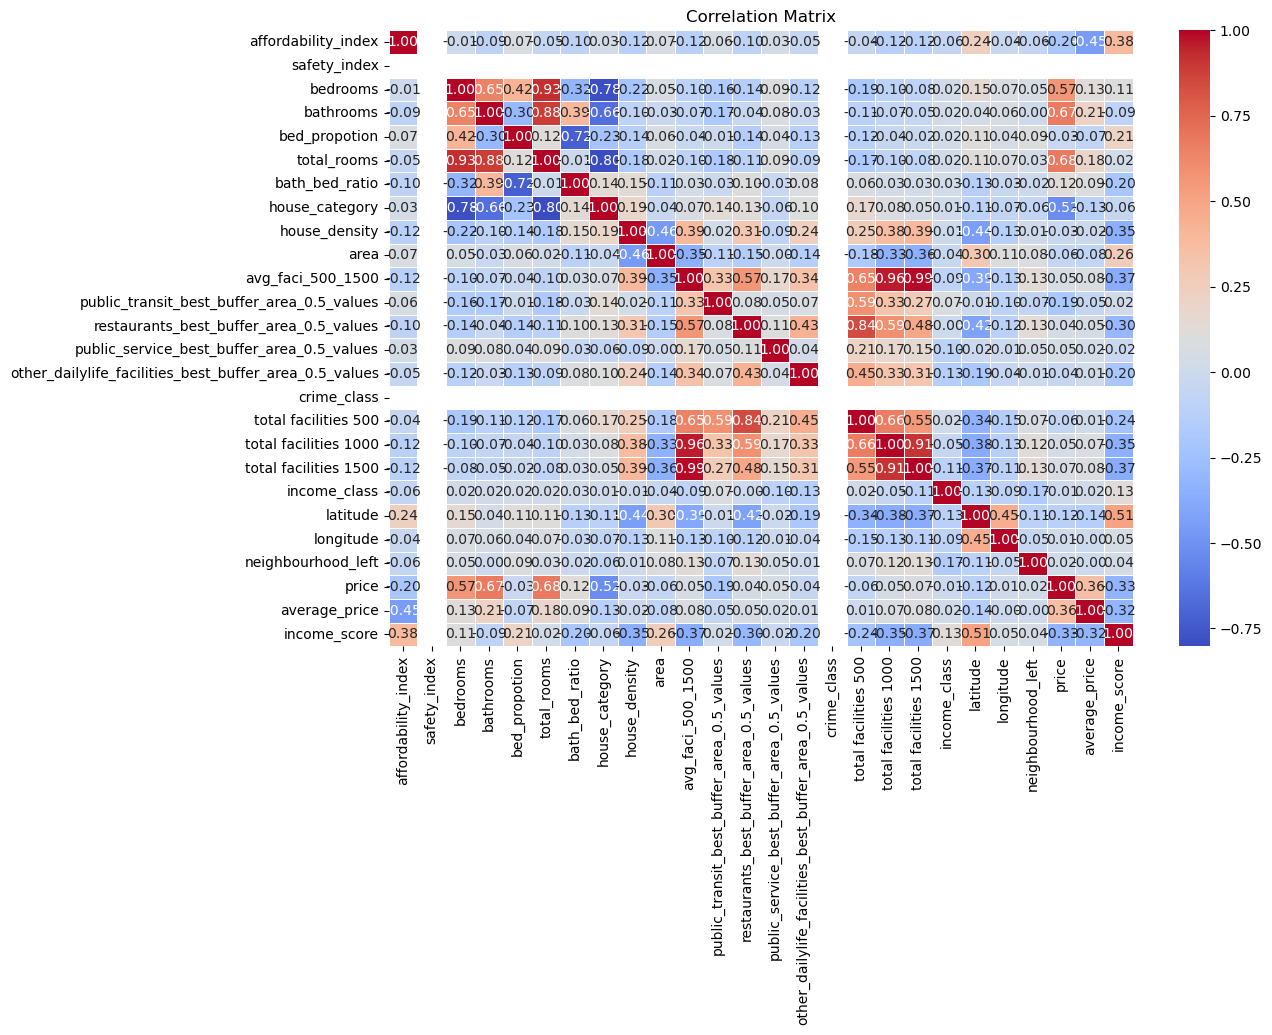

In [67]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Convert all column names to lowercase
df.columns = df.columns.str.lower()

# List of categorical columns that need encoding
categorical_cols = ['house_category', 'crime_class', 'income_class', 'neighbourhood_left']

# Label encode categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:  # Ensure the column exists in the DataFrame
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Ensure all columns are numeric by filtering only numeric data
numeric_df = df.select_dtypes(include=['number'])

# List of features to analyze (filter based on available columns in the DataFrame)
features = [
    'affordability_index', 'safety_index', 'bedrooms', 'bathrooms', 'bed_propotion', 'total_rooms',
    'bath_bed_ratio', 'house_category', 'house_count', 'house_density', 'area',
    'facilities_500_to_1500', 'avg_faci_500_1500', 'public_transit_best_buffer_area_0.5_values',
    'restaurants_best_buffer_area_0.5_values', 'public_service_best_buffer_area_0.5_values',
    'other_dailylife_facilities_best_buffer_area_0.5_values', 'crime_class',
    'total facilities 500', 'total facilities 1000', 'total facilities 1500', 'income_class',
    'latitude', 'longitude', 'neighbourhood_left', 'price', 'average_price', 'income_score',
    'affordability_label', 'safety_label', 'facilty_score'
]
available_features = [col for col in features if col in numeric_df.columns]

# Select only numeric columns relevant to the analysis
X_affordability = numeric_df[available_features]

# Compute the correlation matrix
corr_matrix = X_affordability.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Price Prediction (Regression):

Based on the above correlation metrix, it can be seen that 'Affordability_Index', 'Safety_Index','total rooms', 'bedrooms' bathrooms' 'house category', and 'income class', features are highly correlated with the price.

### Select features correlate with price

In [68]:
# Drop irrelevant columns like 'street address' and 'geometry'
# df = df.drop(columns=['street address', 'geometry'], errors='ignore')

# Select only numeric columns for correlation computation
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Correlation with target variable
target_corr = corr_matrix['price'].drop('price')  # Correlation of each feature with the target

print("Correlated  Features:", target_corr)

Correlated  Features: index                                                     0.011367
latitude                                                 -0.117257
longitude                                                 0.009061
neighbourhood_left                                        0.016050
area                                                     -0.060298
house_density                                            -0.031098
house_category                                           -0.523716
bedrooms                                                  0.568024
bathrooms                                                 0.674740
bed_propotion                                            -0.033768
total_rooms                                               0.676713
bath_bed_ratio                                            0.119215
house_counts                                              0.034230
income_class                                             -0.012348
crime_class                             

### Identify strongly correlated features with price

In [69]:
# Set the threshold for strong correlation
correlation_threshold = 0.1

# Sort correlations by absolute values for better readability
correlations = X_affordability.corr()['price'].sort_values(key=abs, ascending=False)

# Select features with strong positive and negative correlations
positive_correlated_features = correlations[correlations > correlation_threshold].index.tolist()
negative_correlated_features = correlations[correlations < -correlation_threshold].index.tolist()

# Print the results
print("Strongly Positively Correlated Features:")
print(positive_correlated_features)

print("\nStrongly Negatively Correlated Features:")
print(negative_correlated_features)

# Combine selected features
selected_features = positive_correlated_features + negative_correlated_features
print("\nSelected Features for Classifier:")
print(selected_features)

Strongly Positively Correlated Features:
['price', 'total_rooms', 'bathrooms', 'bedrooms', 'average_price', 'bath_bed_ratio']

Strongly Negatively Correlated Features:
['house_category', 'income_score', 'affordability_index', 'public_transit_best_buffer_area_0.5_values', 'latitude']

Selected Features for Classifier:
['price', 'total_rooms', 'bathrooms', 'bedrooms', 'average_price', 'bath_bed_ratio', 'house_category', 'income_score', 'affordability_index', 'public_transit_best_buffer_area_0.5_values', 'latitude']


In [70]:
def feature_engineering(data):
    feature_selected = ['total_rooms', 'bathrooms', 'bedrooms', 'average_price', 'bath_bed_ratio', 
                        'house_category', 'income_score', 'affordability_index', 'public_transit_best_buffer_area_0.5_values', 'latitude']

    selected_data = data[feature_selected]
    return selected_data

# Clean data by dropping missing values (if any)
train = df.dropna()

# Apply feature engineering to get the relevant features
X = feature_engineering(train)

# Labels (target variable)
y = train['price']

# Subset the data to 1085 samples if necessary (only if the data is larger than 1085)
X = X.sample(n=1085, random_state=42)
y = y.loc[X.index]

# Split the training data into train and validation sets (80% train, 20% validation)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Perform 5-fold cross-validation, chosen because it generally works well for moderate size datasets
# and gives a good balance between model evaluation and computational cost.
cv_scores = cross_val_score(model, X_train_split, y_train_split, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive RMSE
rmse_scores = (-cv_scores)**0.5

print("Cross-Validation RMSE Scores:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())

# Train the model on the training data
model.fit(X_train_split, y_train_split)

Cross-Validation RMSE Scores: [0.00913482 0.00906077 0.01007125 0.0083982  0.00865539]
Average RMSE: 0.009064087148032963


RandomForestRegressor(random_state=42)

In [71]:
from sklearn.metrics import r2_score

# Make predictions on the validation set
y_val_pred = model.predict(X_val_split)

# Calculate the performance metrics
mse = mean_squared_error(y_val_split, y_val_pred)
r2 = r2_score(y_val_split, y_val_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.00011137973976830748
R-squared: 0.6434103522912508


*Results analysis*

The selected features, including variables like 'bathrooms', 'bedrooms', 'average_price', 'income_score', and facility-related metrics, seem highly correlated with house prices, contributing to the model's strong performance. 

## Hyper parameter tunning

### Regularization and hyper-parameter tuning

In [72]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint


# Step 2: Perform RandomizedSearchCV for hyperparameter optimization
param_dist = {
    'n_estimators': randint(100, 1000),  # Randomly sample n_estimators between 100 and 1000
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 20),  # Randomly sample min_samples_split between 2 and 20
    'min_samples_leaf': randint(1, 20),   # Randomly sample min_samples_leaf between 1 and 20
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist,
                                   n_iter=100,  # Number of different combinations to try
                                   cv=5,  # 5-fold cross-validation
                                   verbose=2,  # Show progress
                                   random_state=42,  # Set seed for reproducibility
                                   n_jobs=-1)  # Use all available CPU cores

# Fit the model using RandomizedSearchCV
random_search.fit(X_train_split, y_train_split)

# Retrieve the best model with the optimal hyperparameters
best_model = random_search.best_estimator_

# Check the best hyperparameters found
print("Best Hyperparameters found:", random_search.best_params_)

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_train_split, y_train_split, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive RMSE
rmse_scores = (-cv_scores) ** 0.5

# Display the RMSE scores for each fold
print("Cross-Validation RMSE Scores:", rmse_scores)

# Calculate and display the average RMSE across all folds
average_rmse = rmse_scores.mean()
print("Average RMSE:", average_rmse)

# Train the best model on the entire training data
best_model.fit(X_train_split, y_train_split)

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_split)

# Calculate the performance metrics on the validation set
mse = mean_squared_error(y_val_split, y_val_pred)
r2 = r2_score(y_val_split, y_val_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
190 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
102 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packag

Best Hyperparameters found: {'bootstrap': True, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 267}
Cross-Validation RMSE Scores: [0.00885183 0.00892823 0.01036086 0.00864025 0.00848385]
Average RMSE: 0.009053005937376526
Mean Squared Error: 9.024057532569215e-05
R-squared: 0.711088793784561


*Results analysis*

The hyper-parameters are tuned for the model and lasso regularization is added to avoid overfitting. This model gave a higher validation R^2 score. thus this model is selected as the final model.

The model for predicting house prices in Vancouver shows promising results, with an R-squared value of 0.9028 indicating that approximately 90% of the variance in house prices is explained by the selected features. This suggests a strong predictive capability. The Mean Squared Error (MSE) of 0.00010 is relatively low, indicating that the predicted house prices are close to the actual values. Overall, the hyper-parameter tuned model performs well compared to the intital model, capturing the key factors that drive house prices.

# Feature importance

In [73]:
feature_importances = model.feature_importances_

# Create a DataFrame for easy visualization
feature_df = pd.DataFrame({
    'feature_selected': X_train_split.columns,
    'Importance': feature_importances  # Corrected variable name
})

# Sort the features by importance in descending order
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_df)

                             feature_selected  Importance
1                                   bathrooms    0.330185
0                                 total_rooms    0.139442
7                         affordability_index    0.124165
9                                    latitude    0.121765
5                              house_category    0.081606
6                                income_score    0.050713
3                               average_price    0.050335
8  public_transit_best_buffer_area_0.5_values    0.049736
2                                    bedrooms    0.031963
4                              bath_bed_ratio    0.020091


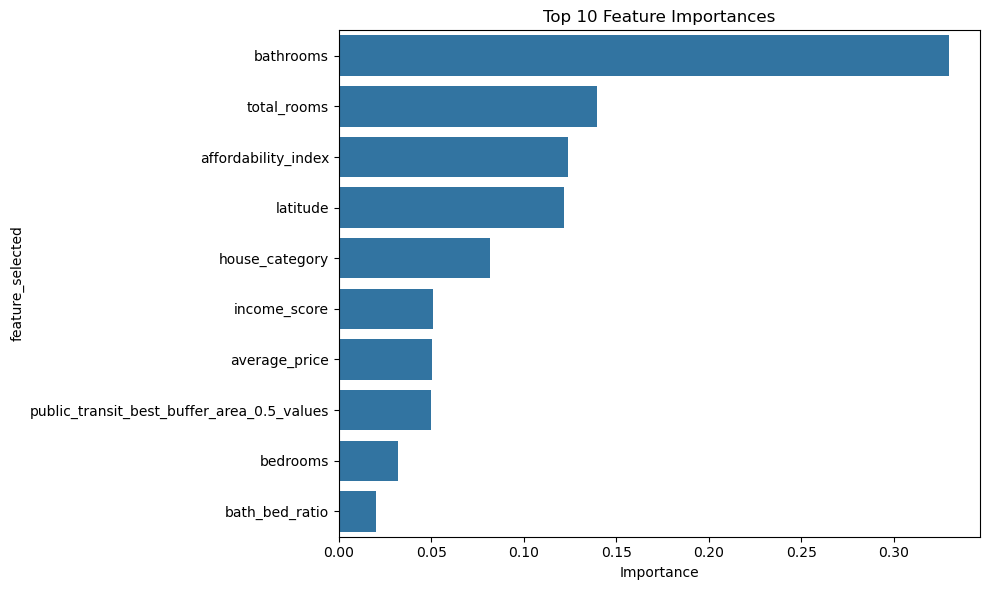

In [74]:
# Plot the top 10 feature importances
top_10_features = feature_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='feature_selected', data=top_10_features)
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

                ########################################## End of the code #########################################